In [1]:
source("~/software/notebook_assist/functions.R")
source("~/software/notebook_assist/packages.R")
library(igraph)
library(pheatmap)
setwd("/projects/CARDIPS/analysis/epigenome_resource/")



Attaching package: ‘igraph’


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union




In [2]:
theme_bw2 = theme_bw() +
    theme(
        axis.text = element_text(size = 12),
        strip.text = element_text(size = 12),
        axis.title = element_text(size = 12),
        legend.text = element_text(size = 12),
        legend.title = element_text(size = 12),
        legend.position = "top"
    )

### Load all lead variants from iPSCORE and GTEx QTLs

In [3]:
leads = fread("analyses/jennifer/ipscore_unique_qtls/mashr/2024_0911/input/ipscore_gtex_leadvars_stats.txt",
                     sep="\t",
                     data.table = F)

In [297]:

length(unique(mashr$gene_id))
length(unique(mashr$variant_id))

nrow(mashr)

[1] 33793

[1] 250564

[1] 281938

In [4]:
mashr = fread("analyses/jennifer/ipscore_unique_qtls/mashr/2024_0911/results/mashr_results.txt",sep="\t",data.table=F)

mashr$gene_id = str_extract(mashr$gene_variant, "^ENSG[0-9]+") 
mashr$variant_id = str_extract(mashr$gene_variant, "VAR_[0-9]+_[0-9]+_[A-Z]_[A-Z]") 


mashr$min_ipscore_lfsr = rowMins(data.matrix(mashr[,6:8]))
mashr$min_adult_lfsr    = rowMins(data.matrix(mashr[,c(9:55)]))
mashr$min_lfsr         = rowMins(data.matrix(mashr[,c(6:55)]))

mashr2 = mashr[ mashr$min_lfsr < 0.05 & mashr$ngtex_tested > 0 & mashr$nipscore_tested > 0 , ]


In [402]:
nrow(mashr) 
nrow(mashr2)

[1] 281938

[1] 102375

In [5]:
mashr2$Category = ifelse(mashr2$min_adult_lfsr < 0.05 & mashr2$min_ipscore_lfsr < 0.05, "Shared",
                              ifelse(mashr2$min_adult_lfsr > 0.05 & mashr2$min_ipscore_lfsr < 0.05, "EDev",
                                    ifelse(mashr2$min_adult_lfsr < 0.05 & mashr2$min_ipscore_lfsr > 0.05,
                                           "Adult", "Not Significant")))

mashr2$variant_id = gsub("VAR_","",str_extract(mashr2$gene_variant, "VAR_.*"))
table(mashr2$Category)

kgenomes = fread("/projects/CARDIPS/analysis/epigenome_resource/analyses/jennifer/gwas_independent/reference/combined.renamed.bim",
                 sep="\t",
                data.table=F)

mashr2$in_kg = ifelse(mashr2$variant_id %in% kgenomes$V2, "TRUE","FALSE")
mashr3 = mashr2[ mashr2$in_kg == "TRUE",]


 Adult   EDev Shared 
 27881   2299  72195 

In [14]:
write_snps = lapply(unique(mashr3$gene_id), function(gene){
    genedf = mashr3[ mashr3$gene_id == gene,]
    snpid = gsub("VAR_","",genedf$variant_id)
    if(length(unique(snpid)) > 1) {
        writeLines(unique(snpid),
               paste0("analyses/tim/ld_modules/mashr_ld/snps/",gene,"_snps.txt"))
        }
})

### Run 03.8.calculate_egene_ld_mashr.sh to identify SNP-eGene pairs representing the same signal

In [6]:
ld.fs = list.files("analyses/tim/ld_modules/mashr_ld/ld", full.names = T, pattern =".ld")
length(ld.fs)

psize(10,10)
read_ld = rbindlist(lapply(ld.fs, function(ld.f){
    gene = gsub(".ld","",gsub("analyses/tim/ld_modules/mashr_ld/ld/","",ld.f))
    all.ld = fread(ld.f,sep=" ",data.table=F)[,c("SNP_A","SNP_B","R2")]
    all.ld$dist = abs(as.numeric(gsub("[0-9]+_","",str_extract(all.ld$SNP_A, "[0-9]+_[0-9]+")))-
                     as.numeric(gsub("[0-9]+_","",str_extract(all.ld$SNP_B, "[0-9]+_[0-9]+"))))

    if (nrow(all.ld) > 0 ){
    in.ld = all.ld[ all.ld$R2 >= 0.8 & all.ld$dist < 100000,]
    verts = data.frame(ids = unique(c(all.ld$SNP_A,all.ld$SNP_B)))
    g = graph_from_data_frame(in.ld, directed = FALSE, vertices = verts)
    cl = cluster_louvain(g)
    verts$gene_id = gene
    verts$cluster_id = paste(gene,cl$membership,sep="_")
    verts$variant_id = paste("VAR",verts$ids,sep="_")
    return(verts)}
}))

[1] 10343

### Add back SNPs that are the only lead variant for a given eGene

In [7]:

single_qtl = mashr3[ mashr3$gene_id %in% names(table(mashr3$gene_id))[ table(mashr3$gene_id) == 1],]
single_qtl$ids = gsub("VAR_","",single_qtl$variant_id)
single_qtl$cluster_id = paste(single_qtl$gene_id,1,sep="_")


[1] 630

In [8]:
mashr3$variant_id = str_extract(mashr3$gene_variant, "VAR_.*")

In [9]:
mashr4 = rbind(merge(mashr3,read_ld,by=c("gene_id","variant_id")),
                       single_qtl)


### Identify QTL clusters that have more than one Category and mark as Shared

In [12]:
cats = unique(mashr4[ ,c("Category","cluster_id")])
cats_dups = cats[ cats$cluster_id %in% names(table(cats$cluster_id))[ table(cats$cluster_id) > 1],]

In [13]:
mashr4$AdjCategory = ifelse(mashr4$cluster_id %in% cats_dups$cluster_id, "Shared",mashr4$Category)

In [14]:
mashr5 = unique(mashr4[,c("gene_id","ntissues_tested","ngtex_tested",
                                          "min_lfsr","min_adult_lfsr","min_ipscore_lfsr","gene_variant","cluster_id","AdjCategory")])



### Identify most significant SNPs in each QTL

In [15]:
mashr6 = mashr5 %>% group_by(cluster_id) %>% top_n(1,-log10(min_lfsr)) %>% top_n(1,ntissues_tested)

In [403]:
nrow(mashr6)

[1] 67269

### Select random SNP-eGene pair when there are equally significant pairs in a QTL signal

In [16]:
mashr7 = mashr6 %>% group_by(cluster_id) %>% sample_n(1)

In [17]:
nrow(mashr7)

[1] 57364

In [18]:
length(unique(mashr7$gene_id))
nrow(mashr7)
table(mashr7$AdjCategory)

[1] 10971

[1] 57364


 Adult   EDev Shared 
 20539   2207  34618 

In [19]:
lead_stats_ipsc_var = leads[leads$gene_variant %in% mashr7$gene_variant,]
lead_stats_cast = reshape2::dcast(gene_variant ~ tissue, data = lead_stats_ipsc_var, fun.aggregate = mean, value.var="beta")
rownames(lead_stats_cast) = lead_stats_cast$gene_variant
lead_stats_cast$gene_variant = NULL
lead_stats_mat = data.matrix(lead_stats_cast)

# Calculate row means considering NA values
row_means <- rowMeans(lead_stats_mat, na.rm = TRUE)

# Replace NA with row means
lead_stats_mat = t(apply(lead_stats_mat, 1, function(x) {
  x[is.na(x)] = row_means[which(is.na(x))] 
  return(x)
}))




In [224]:
length(unique(mashr7$gene_id[ mashr7$AdjCategory == "Adult"]))
length(unique(mashr7$gene_id[ mashr7$AdjCategory == "EDev"]))
length(unique(mashr7$gene_id[ mashr7$AdjCategory == "Shared"]))

[1] 7165

[1] 1919

[1] 9229

In [23]:
figure3a = as.data.frame(table(mashr7$AdjCategory))
figure3a$Specificity = factor(figure3a$Var1, levels = c("EDev","Adult","Shared"))
figure3a$No_eQTLs = figure3a$Freq
fwrite(figure3a[,3:4], "~/projects/Resource/notebooks/toGitHub/sourcedata/SOURCEDATA.FIGURE3A.txt",
      sep="\t",row.names=F,quote=F)

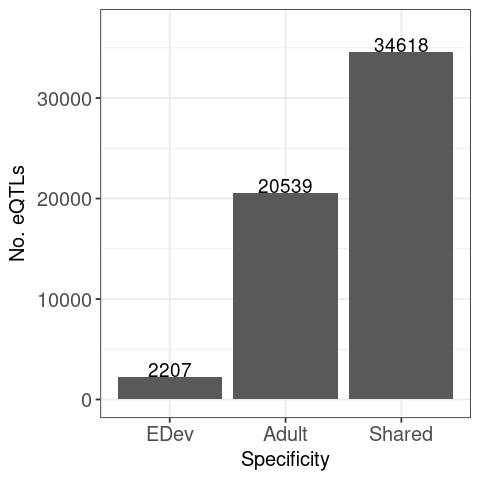

### Correlation of EDev, Adult and Shared eQTLs across iPSCORE and GTEx tissues

In [42]:

edev_cor = cor(lead_stats_mat[ rownames(lead_stats_mat) %in% mashr7$gene_variant[ mashr7$AdjCategory == "EDev"],])

shar_cor = cor(lead_stats_mat[ rownames(lead_stats_mat) %in% mashr7$gene_variant[ mashr7$AdjCategory == "Shared"],])
adult_cor = cor(lead_stats_mat[ rownames(lead_stats_mat) %in% mashr7$gene_variant[ mashr7$AdjCategory == "Adult"],])


edev_melt = melt(edev_cor)
edev_melt$Type = "EDev"
shar_melt = melt(shar_cor)
shar_melt$Type = "Shared"
adult_melt = melt(adult_cor)
adult_melt$Type = "Adult"

melted = rbind(rbind(edev_melt,shar_melt),adult_melt) %>% filter(Var1 != Var2)
melted$Tissue1 = as.character(melted$Var1)
melted$Tissue2 = as.character(melted$Var2)
melted$r2 = melted$value**2
melted$Var1 = NULL
melted$Var2 = NULL
melted2 = melted[!duplicated(apply(melted,1,function(x) paste(sort(x),collapse=''))),]
melted3 = melted2[ melted2$Tissue1 %in% c("iPSC","CVPC","PPC") |  melted2$Tissue2 %in% c("iPSC","CVPC","PPC"),]
melted4 = melted3 [ !(melted3$Tissue1 == "iPSC" &  melted3$Tissue2 == "CVPC") &
                     !(melted3$Tissue1 == "PPC" &  melted3$Tissue2 == "iPSC") &
                     !(melted3$Tissue1 == "PPC" &  melted3$Tissue2 == "CVPC"),]
melted4$`iPSCORE Tissue` = ifelse(melted4$Tissue1 %in% c("iPSC","CVPC","PPC"), melted4$Tissue1,
                                  ifelse(melted4$Tissue2 %in% c("iPSC","CVPC","PPC"), melted4$Tissue2, NA))
melted4$`iPSCORE Tissue` = factor(melted4$`iPSCORE Tissue`, levels = c("iPSC","CVPC","PPC"))
melted4$`QTL Specificity` = factor(melted4$Type, levels = c("EDev","Adult","Shared"))
melted4 %>% group_by(`QTL Specificity`) %>% summarise(mean_r = mean(r2))



Warning message:
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(edev_cor). In the next version, this warning will become an error.”
Warning message:
“The melt generic in data.table has been passed a matrix and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is superseded and is no longer actively developed, and this redirection is now deprecated. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace, i.e. reshape2::melt(shar_cor). In the next version, this warning will become an error.”
Warning message:
“The melt generic in data.table has been passed

QTL Specificity,mean_r
<fct>,<dbl>
EDev,0.001188834
Adult,0.004061838
Shared,0.211740161


In [26]:
fwrite(melted4, 
      "~/projects/Resource/notebooks/toGitHub/sourcedata/SOURCEDATA.FIGURE3B.txt",sep="\t",row.names=F,quote=F)

In [27]:
melted4 %>% group_by(`QTL Specificity`) %>% summarise(mean_r = mean(value))
t.test(melted4$r2[ melted4$`QTL Specificity` == "EDev"],
      melted4$r2[ melted4$`QTL Specificity` == "Adult"])$p.value

t.test(melted4$r2[ melted4$`QTL Specificity` == "EDev"],
      melted4$r2[ melted4$`QTL Specificity` == "Shared"])$p.value

t.test(melted4$r2[ melted4$`QTL Specificity` == "Adult"],
      melted4$r2[ melted4$`QTL Specificity` == "Shared"])$p.value

QTL Specificity,mean_r
<fct>,<dbl>
EDev,0.02003603
Adult,-0.05646204
Shared,0.45889373


[1] 1.497787e-12

[1] 1.12378e-119

[1] 7.57729e-121

In [43]:
gene_info = fread("/reference/private/Gencode.v44lift38/gene_info.txt",sep="\t",data.table=F)
gene_info$simple_gene = gsub(".[0-9]+$","",gene_info$gene_id)
mashr7$pos = as.numeric(gsub("_[A-Z]+","",str_extract(mashr7$gene_variant, "[0-9]+_[A-Z]+")))
gene_info_key = gene_info[,c("start","end","strand","simple_gene")] %>% rename(gene_id = simple_gene)
gene_info_key$tss = ifelse(gene_info_key$strand == "+",gene_info_key$start,gene_info_key$end)
mashr8 = merge(mashr7,gene_info_key[,c("gene_id","tss")])
mashr8$dist = abs(mashr8$tss - mashr8$pos)

mashr9 = aggregate(dist ~   gene_id + AdjCategory, data = mashr8 , FUN = min)
psize(3,3)
mashr9$Category = factor(mashr9$AdjCategory, levels = c("EDev","Adult","Shared"))


In [30]:
fwrite(mashr9,"~/projects/Resource/notebooks/toGitHub/sourcedata/SOURCEDATA.FIGURE3C.txt",sep="\t",row.names=F,quote=F)

In [231]:
wilcox.test(mashr9$dist[ mashr9$AdjCategory == "EDev"],
           mashr9$dist[ mashr9$AdjCategory == "Adult"])$p.value

wilcox.test(mashr9$dist[ mashr9$AdjCategory == "EDev"],
           mashr9$dist[ mashr9$AdjCategory == "Shared"])$p.value

wilcox.test(mashr9$dist[ mashr9$AdjCategory == "Adult"],
           mashr9$dist[ mashr9$AdjCategory == "Shared"])$p.value

wilcox.test(mashr9$dist[ mashr9$AdjCategory == "Shared"],
           mashr9$dist[ mashr9$AdjCategory != "Shared"])$p.value

[1] 0

[1] 0

[1] 1.905084e-212

[1] 0

In [232]:
median(mashr9$dist[ mashr9$Category == "EDev"])/1000
median(mashr9$dist[ mashr9$Category == "Adult"])/1000
median(mashr9$dist[ mashr9$Category == "Shared"])/1000

[1] 220.765

[1] 20.125

[1] 7.257

## Annotate eQTLs

In [44]:
filtered_qtls = fread("analyses/tim/gwas_coloc/scripts/qtls_090424.txt",sep="\t",data.table=F)
eqtls = filtered_qtls[ filtered_qtls$type == 0 & grepl("^E",filtered_qtls$element_id),]

eqtls$gene_id = gsub(".[0-9]+$","",eqtls$element_id)
eqtls$variant_id = eqtls$id
eqtls$gene_variant = paste(eqtls$gene_id, eqtls$variant_id)


eqtls$Category = ifelse(eqtls$gene_variant %in% mashr5$gene_variant[ mashr5$AdjCategory == "EDev"], "EDev",
                       ifelse(eqtls$gene_variant %in% mashr5$gene_variant[ mashr5$AdjCategory == "Shared"], "Shared","No Association"))

table(eqtls$Category, eqtls$tissue)    
eqtls$tissue = factor(eqtls$tissue, levels = c("iPSC","CVPC","PPC"))
psize(3,3)

wilcox.test(abs(eqtls$beta[ eqtls$Category == "EDev" & eqtls$tissue == "iPSC"]),
               abs(eqtls$beta[ eqtls$Category == "Shared"& eqtls$tissue == "iPSC"]))$p.value
wilcox.test(abs(eqtls$beta[ eqtls$Category == "EDev" & eqtls$tissue == "CVPC"]),
               abs(eqtls$beta[ eqtls$Category == "Shared"& eqtls$tissue == "CVPC"]))$p.value
wilcox.test(abs(eqtls$beta[ eqtls$Category == "EDev" & eqtls$tissue == "PPC"]),
               abs(eqtls$beta[ eqtls$Category == "Shared"& eqtls$tissue == "PPC"]))$p.value

                
                 CVPC iPSC  PPC
  EDev            900 1068  248
  No Association 1116 3042 2076
  Shared         2821 4902 3132

[1] 2.252503e-06

[1] 7.904659e-71

[1] 1.449785e-15

In [50]:
fwrite(eqtls[eqtls$Category %in% c("EDev","Shared"),c("element_id","tissue","beta","Category","path")],
       "~/projects/Resource/notebooks/toGitHub/sourcedata/SOURCEDATA.FIGURE3E.txt",
       sep="\t",row.names=F,quote=F)